In [ ]:
!pip install pandas numpy scikit-learn xgboost matplotlib


import pandas as pd
import numpy as np

df = pd.read_csv("classified_companies.csv")

df = df.sort_values(by=["Company Name", "Year"])

features = [
    "Net Working Capital ( Incl. Def. Tax)",
    "Debt-Equity Ratio",
    "Long Term Debt-Equity Ratio",
    "Current Ratio",
    "Interest Cover Ratio",
    "ROCE (%)",
    "PBIDTM (%)",
    "PBITM (%)",
    "APATM (%)",
    "RONW (%)",
    "ROE (X)",
    "EPS (annualised) (Unit Curr)",
    "Net Sales",
    "Gross Sales",
    "Value Of Output",
    "Price to Book Value ( P/BV)",
    "Price Earning (P/E)",
    "EV/EBIDTA",
    "Market Cap/Sales",
    "Book Value",
    "Cash Flow From Operating Activities",
    "Total Income",
    "Gross Profit"
]

threshold_gt= {
    "Net Working Capital ( Incl. Def. Tax)": 0,
    "Current Ratio": 1.5,
    "Interest Cover Ratio": 3,
    "ROCE (%)": 15,
    "PBIDTM (%)": 10,
    "PBITM (%)": 10,
    "APATM (%)": 8,
    "RONW (%)":12,
    "ROE (X)": 12,
    "EPS (annualised) (Unit Curr)": 5,
    "Cash Flow From Operating Activities": 0,
    }

threshold_lt= {
    "Debt-Equity Ratio": 1.5,
    "Long Term Debt-Equity Ratio": 1,
    "Price to Book Value ( P/BV)": 3,
    "Price Earning (P/E)": 15,
    "EV/EBIDTA": 10,
    "Market Cap/Sales": 2,
    }

threshold_comp= [
    "Net Sales" ,
    "Gross Sales",
    "Value Of Output",
    "Book Value",
    "Total Income",
    "Gross Profit"
]

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.dropna(subset=features, how="all", inplace=True)

lag_years = 3
lagged_data = {}

for feature in features:
    for lag in range(1, lag_years + 1):
        lagged_data[f"{feature}_t-{lag}"] = df.groupby("Company Name")[feature].shift(lag)

df = pd.concat([df, pd.DataFrame(lagged_data)], axis=1)

df.fillna(0, inplace=True)

for feature in features:
    if feature in threshold_gt:
        lagged_cols = [f"{feature}_t-{lag}" for lag in range(1, lag_years + 1)]
        if all(col in df.columns for col in lagged_cols):
            df[f"{feature}_Flag"] = df[lagged_cols].gt(threshold_gt[feature]).all(axis=1).astype(int)
        else:
            print(f"Some {feature} lagged columns are missing.")

    elif feature in threshold_lt:
        lagged_cols = [f"{feature}_t-{lag}" for lag in range(1, lag_years + 1)]
        if all(col in df.columns for col in lagged_cols):
            df[f"{feature}_Flag"] = df[lagged_cols].lt(threshold_lt[feature]).all(axis=1).astype(int)
        else:
            print(f"Some {feature} lagged columns are missing.")

    elif feature in threshold_comp:
        lagged_cols = [f"{feature}_t-{lag}" for lag in range(1, lag_years + 1)]
        if all(col in df.columns for col in lagged_cols):
            df[f"{feature}_Flag"] = df.apply(
            lambda row: 1 if (row[lagged_cols[0]] > row[lagged_cols[1]] and
                              row[lagged_cols[1]] > row[lagged_cols[2]]) else 0, axis=1
        )
        else:
            print(f"Some {feature} lagged columns are missing.")

    else:
        print(f"{feature} is not in the list.")


volatility_data = {}

for feature in features:
    volatility_data[f"{feature}_3yr_Std"] = df.groupby("Company Name")[feature] \
        .rolling(window=3, min_periods=1) \
        .std().reset_index(level=0, drop=True)

df = pd.concat([df, pd.DataFrame(volatility_data)], axis=1)

moving_avg_features = {f"{feature}_3yr_MA": df.groupby("Company Name")[feature].rolling(window=3).mean().reset_index(level=0, drop=True)
                       for feature in features}

df = pd.concat([df, pd.DataFrame(moving_avg_features)], axis=1)



df.dropna(inplace=True)

df.to_csv("processed_financial_data.csv", index=False)

<ipython-input-1-5d7af9cf1e32>:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("classified_companies.csv")


In [ ]:
!pip install --upgrade xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.9 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt


df = pd.read_csv("processed_financial_data.csv")

df.sort_values(by=["Company Name", "Year"], inplace=True)

target_col = "Performance Label"
grouping_cols = ["Company Name", "Year"]

meta_drop_cols = [
    "Capitaline Code", "NSE Symbol", "BSE Code", "Weighted Score",
    "Financial Year End", "Year End", "Industry", "Listing Status(MCX)", "Company Type"
]

optional_categorical_cols = [
    "Sector"
]

df.drop(columns=[col for col in meta_drop_cols if col in df.columns], inplace=True)
df = df.dropna(subset=[target_col])
df_model = df.copy()

train_years = list(range(2010, 2019))
test_years = list(range(2020, 2024))

train_df = df_model[df_model["Year"].isin(train_years)]
test_df = df_model[df_model["Year"].isin(test_years)]

# Drop grouping columns and target for feature selection
feature_cols = df_model.columns.difference(grouping_cols + [target_col])

X_train_raw = train_df[feature_cols]
y_train = train_df[target_col]

X_test_raw = test_df[feature_cols]
y_test = test_df[target_col]

# One-hot encode categorical metadata
encoder = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         [col for col in optional_categorical_cols if col in df_model.columns])
    ],
    remainder='passthrough'
)

# Fit encoder and transform
X_train_enc = encoder.fit_transform(X_train_raw)
X_test_enc = encoder.transform(X_test_raw)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=10.0,
    reg_lambda=100.0,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=True
)

y_pred = xgb_model.predict(X_test_scaled)


<ipython-input-3-10e6cf521450>:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("processed_financial_data.csv")
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:35:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-logloss:0.67478
[1]	validation_0-logloss:0.66983
[2]	validation_0-logloss:0.66465
[3]	validation_0-logloss:0.65958
[4]	validation_0-logloss:0.65485
[5]	validation_0-logloss:0.65017
[6]	validation_0-logloss:0.64499
[7]	validation_0-logloss:0.64015
[8]	validation_0-logloss:0.63552
[9]	validation_0-logloss:0.63114
[10]	validation_0-logloss:0.62691
[11]	validation_0-logloss:0.62260
[12]	validation_0-logloss:0.61797
[13]	validation_0-logloss:0.61348
[14]	validation_0-logloss:0.60914
[15]	validation_0-logloss:0.60519
[16]	validation_0-logloss:0.60126
[17]	validation_0-logloss:0.59695
[18]	validation_0-logloss:0.59308
[19]	validation_0-logloss:0.58961
[20]	validation_0-logloss:0.58616
[21]	validation_0-logloss:0.58216
[22]	validation_0-logloss:0.57829
[23]	validation_0-logloss:0.57449
[24]	validation_0-logloss:0.57067
[25]	validation_0-logloss:0.56686
[26]	validation_0-logloss:0.56293
[27]	validation_0-logloss:0.55949
[28]	validation_0-logloss:0.55612
[29]	validation_0-loglos

In [ ]:
import xgboost as xgb
print(xgb.__version__)

3.0.0


In [ ]:
# Evaluate
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5564
           1       0.92      0.93      0.92      7960

    accuracy                           0.91     13524
   macro avg       0.91      0.91      0.91     13524
weighted avg       0.91      0.91      0.91     13524

✅ Accuracy: 0.910455486542443


In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# Use X_train_scaled and y_train for cross-validation
model = XGBClassifier()
scores = cross_val_score(model, X_train_scaled, y_train, cv=5)  # 5-fold cross-validation

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


Cross-validation scores: [0.99176172 0.99176172 0.99471905 0.99218255 0.99345024]
Mean cross-validation score: 0.9927750584195625


Confusion Matrix:
[[4931  633]
 [ 578 7382]]

Precision: 0.9210230817217717
Recall: 0.9273869346733669
F1-Score: 0.9241940532081377

ROC-AUC: 0.9787340729528302


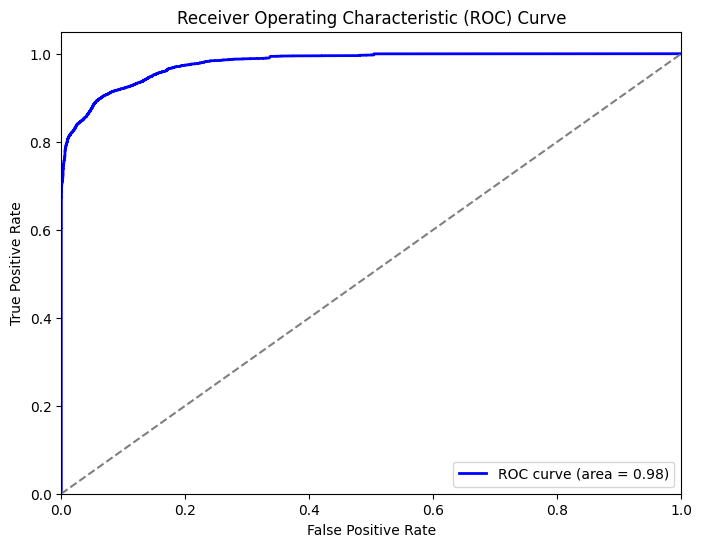

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nPrecision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])  # Probability of positive class
print(f"\nROC-AUC: {roc_auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


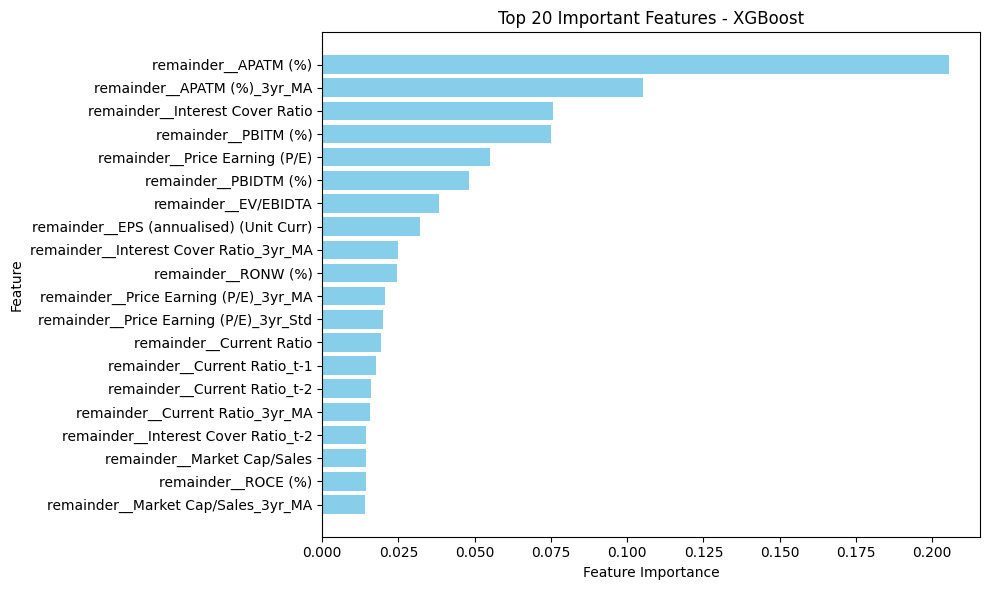

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

encoded_feature_names = encoder.get_feature_names_out()
importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": encoded_feature_names,
    "Importance": importances
})

top_features = importance_df.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Important Features - XGBoost")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()